In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/face/fer2013/fer2013.csv')
grouped = df.groupby('emotion')
res = grouped['pixels'].agg(['count'])
res

,count
emotion,
0,4953
1,547
2,5121
3,8989
4,6077
5,4002
6,6198


In [0]:
list_emotions = ['Angry', 'Disgust', 'Fear', 
                 'Happy', 'Sad', 'Surprise', 'Neutral']

In [0]:
# pixels = df['pixels'].tolist()

In [0]:
# pixels[:5]

In [0]:
# import numpy as np
# import cv2

# width, height = 48, 48

# X = []

# for pixel_sequence in pixels:
#     face = [int(pixel) for pixel in pixel_sequence.split(' ')]
#     face = np.array(face).reshape(width, height)
#     X.append(face)
    
# X = np.array(X)
# X.shape

In [0]:
# labels = df['emotion'].tolist()

In [0]:
# y = np.array(labels)
# y.shape

In [0]:
# np.save('data_face', X)

In [0]:
# np.save('labels_face', y)

In [0]:
# !cp 'labels_face.npy' '/content/drive/My Drive/face'

In [0]:
import numpy as np

X = np.load('/content/drive/My Drive/face/data_face.npy')
y = np.load('/content/drive/My Drive/face/labels_face.npy')

In [0]:
from keras.utils import to_categorical

# reshape jadi 4 rank
X = X.reshape(-1, 48, 48, 1)

# biar bisa jalan
y = to_categorical(y)


Using TensorFlow backend.


In [0]:
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Activation, Convolution2D, Dropout, Conv2D
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import pandas as pd
import cv2
import numpy as np

In [0]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True,
                        validation_split=0.25,
                        rescale=1./255.
)

# parameters
batch_size = 32
num_epochs = 110
input_shape = (48, 48, 1)
verbose = 1
num_classes = 7
patience = 50
base_path = 'models/'
l2_regularization=0.01

train_generator = data_generator.flow(
    X,
    y,
    batch_size=batch_size,
    shuffle=True,
    subset='training'
)

valid_generator = data_generator.flow(
    X,
    y,
    batch_size=batch_size,
    shuffle=True,
    subset='validation'
)

In [0]:
# parameters
batch_size = 32
num_epochs = 50
input_shape = (48, 48, 1)
verbose = 1
num_classes = 7
patience = 50
base_path = 'models/'
l2_regularization=0.01
 
# model parameters
regularization = l2(l2_regularization)
 
# base
img_input = Input(input_shape)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
 
# module 1
residual = Conv2D(16, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 2
residual = Conv2D(32, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 3
residual = Conv2D(64, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 4
residual = Conv2D(128, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
x = Conv2D(num_classes, (3, 3), padding='same')(x)
x = GlobalAveragePooling2D()(x)
output = Activation('softmax',name='predictions')(x)
 
model = Model(img_input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

W0824 05:11:46.331550 140650608134016 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 46, 46, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 46, 46, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 46, 46, 8)    0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
# callbacks
# log_file_path = base_path + '_emotion_training.log'
# csv_logger = CSVLogger(log_file_path, append=False)
# early_stop = EarlyStopping('val_loss', patience=patience)
# reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/4), verbose=1)
# trained_models_path = base_path + '_mini_XCEPTION'
# model_names = trained_models_path + '.{epoch:02d}-{val_acc:.2f}.hdf5'
# model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
# callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr] 
    
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=num_epochs,
                              verbose=1,
)

# model.fit_generator(data_generator.flow(X, y, batch_size),
#                         steps_per_epoch=len(xtrain) / batch_size,
#                         epochs=num_epochs, verbose=1, callbacks=callbacks,
#                         validation_data=(xtest,ytest))

Epoch 1/50
841/841 [==============================] - 42s 50ms/step - loss: 1.8029 - acc: 0.3114 - val_loss: 1.8106 - val_acc: 0.3092
Epoch 2/50
841/841 [==============================] - 37s 44ms/step - loss: 1.5442 - acc: 0.4193 - val_loss: 1.5583 - val_acc: 0.4109
Epoch 3/50
841/841 [==============================] - 36s 43ms/step - loss: 1.4190 - acc: 0.4664 - val_loss: 1.4514 - val_acc: 0.4527
Epoch 4/50
841/841 [==============================] - 36s 43ms/step - loss: 1.3462 - acc: 0.4943 - val_loss: 1.3833 - val_acc: 0.4852
Epoch 5/50
841/841 [==============================] - 36s 43ms/step - loss: 1.2874 - acc: 0.5163 - val_loss: 1.4291 - val_acc: 0.4741
Epoch 6/50
841/841 [==============================] - 36s 43ms/step - loss: 1.2602 - acc: 0.5245 - val_loss: 1.2582 - val_acc: 0.5273
Epoch 7/50
841/841 [==============================] - 36s 43ms/step - loss: 1.2267 - acc: 0.5409 - val_loss: 1.2574 - val_acc: 0.5250
Epoch 8/50
841/841 [==============================] - 36s 43ms

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


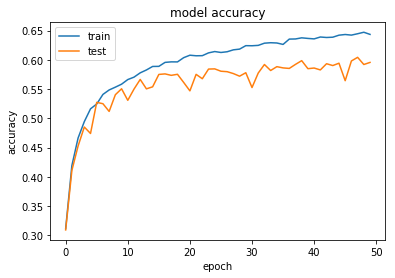

In [0]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

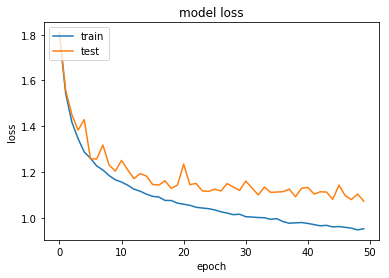

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
!cp 'model.json' '/content/drive/My Drive/face'